(**You can also open this notebook in Google Colab**)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/xiangshiyin/data-programming-with-python/blob/main/2023-fall/2023-10-31/notebook/code_demo.ipynb)

# Regression Analysis - Linear Regression

Suppose you want to know **if money makes people happy**, so you download the Better Life Index data from the OECD’s website and stats about gross domestic product (GDP) per capita from the IMF’s website.
* OECD: https://www.oecdbetterlifeindex.org/
* IMF: https://ourworldindata.org/

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
pd.options.display.max_rows=None
pd.options.display.max_columns=None

## Get the data

In [3]:
oecd_bli = pd.read_csv('../data/oecd-better-life-index.csv',sep=',',header=0)
gdp_per_capita = pd.read_csv('../data/imf-gdp-per-capita.csv',sep=',',header=0,thousands=',')

In [4]:
oecd_bli.head(3)

,LOCATION,Country,INDICATOR,Indicator,MEASURE,Measure,INEQUALITY,Inequality,Unit Code,Unit,PowerCode Code,PowerCode,Reference Period Code,Reference Period,Value,Flag Codes,Flags
0,AUS,Australia,JE_LMIS,Labour market insecurity,L,Value,TOT,Total,PC,Percentage,0,Units,NaN,NaN,5.4,NaN,NaN
1,AUT,Austria,JE_LMIS,Labour market insecurity,L,Value,TOT,Total,PC,Percentage,0,Units,NaN,NaN,3.5,NaN,NaN
2,BEL,Belgium,JE_LMIS,Labour market insecurity,L,Value,TOT,Total,PC,Percentage,0,Units,NaN,NaN,3.7,NaN,NaN


In [5]:
gdp_per_capita.head(3)

,Country,Subject Descriptor,Units,Scale,Country/Series-specific Notes,2015,Estimates Start After
0,Afghanistan,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",599.994,2013.0
1,Albania,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",3995.380,2010.0
2,Algeria,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",4318.140,2014.0


## Transform the data

Get the view of 

| Country | GDP per capita (USD) | Life satisfaction |
|---------|----------------------|-------------------|

### format the oecd data

In [6]:
oecd_bli.Indicator.unique()

array(['Labour market insecurity',
       'Stakeholder engagement for developing regulations',
       'Dwellings without basic facilities', 'Housing expenditure',
       'Feeling safe walking alone at night', 'Rooms per person',
       'Household net adjusted disposable income', 'Household net wealth',
       'Employment rate', 'Long-term unemployment rate',
       'Personal earnings', 'Quality of support network',
       'Educational attainment', 'Student skills', 'Years in education',
       'Air pollution', 'Water quality', 'Voter turnout',
       'Life expectancy', 'Self-reported health', 'Life satisfaction',
       'Homicide rate', 'Employees working very long hours',
       'Time devoted to leisure and personal care'], dtype=object)

In [7]:
oecd_bli.Inequality.unique()

array(['Total', 'Men', 'Women', 'High', 'Low'], dtype=object)

In [8]:
oecd_bli2 = oecd_bli.loc[
    (oecd_bli.Inequality=='Total')&(oecd_bli.Indicator=='Life satisfaction'),
    ['Country','Value']
].rename(columns={'Country':'country','Value':'life_satisfaction'})

In [9]:
oecd_bli2.head(3)

,country,life_satisfaction
1813,Australia,7.3
1814,Austria,7.1
1815,Belgium,6.9


In [10]:
oecd_bli2.tail(3)

,country,life_satisfaction
1851,OECD - Total,6.5
2349,Colombia,6.3
2350,Lithuania,5.9


In [11]:
oecd_bli2.country.nunique()

41

### format the gdp per capita data

In [12]:
gdp_per_capita.Units.unique()

array(['U.S. dollars'], dtype=object)

In [13]:
gdp_per_capita2 = gdp_per_capita.loc[:,['Country','2015']].rename(columns={
    'Country':'country',
    '2015':'gdp_per_capita'
})
gdp_per_capita2.head(3)

,country,gdp_per_capita
0,Afghanistan,599.994
1,Albania,3995.380
2,Algeria,4318.140


In [14]:
gdp_per_capita2.country.nunique()

189

### join the two

In [15]:
country_stats = pd.merge(
    gdp_per_capita2,
    oecd_bli2,
    on='country'
).sort_values(by='gdp_per_capita').reset_index(drop=True)

In [16]:
country_stats.head(3)

,country,gdp_per_capita,life_satisfaction
0,South Africa,5694.57,4.7
1,Colombia,6083.51,6.3
2,Brazil,8670.00,6.4


In [17]:
country_stats.tail(3)

,country,gdp_per_capita,life_satisfaction
37,Norway,74822.11,7.6
38,Switzerland,80675.31,7.5
39,Luxembourg,101994.09,6.9


In [18]:
country_stats.shape

(40, 3)

In [19]:
country_stats.head(3)

,country,gdp_per_capita,life_satisfaction
0,South Africa,5694.57,4.7
1,Colombia,6083.51,6.3
2,Brazil,8670.00,6.4


In [20]:
country_stats[['gdp_per_capita', 'life_satisfaction']].corr()

,gdp_per_capita,life_satisfaction
gdp_per_capita,1.000000,0.720523
life_satisfaction,0.720523,1.000000


## split the data

In [21]:
# remove_indices = [2,3,8,12,37,38,39]
# keep_indices = list(set(range(40)) - set(remove_indices))

countries_remove = ['Brazil','Mexico','Chile','Czech Republic','Norway','Switzerland','Luxembourg']
countries_keep = set(country_stats.country) - set(countries_remove)

In [22]:
# sample_data = country_stats.iloc[keep_indices]
# missing_data = country_stats.iloc[remove_indices]
sample_data = country_stats[country_stats.country.isin(countries_keep)]
missing_data = country_stats[country_stats.country.isin(countries_remove)]

In [23]:
missing_data

,country,gdp_per_capita,life_satisfaction
2,Brazil,8670.00,6.4
3,Mexico,9009.28,6.5
8,Chile,13340.91,6.5
12,Czech Republic,17256.92,6.7
37,Norway,74822.11,7.6
38,Switzerland,80675.31,7.5
39,Luxembourg,101994.09,6.9


In [24]:
sample_data.head(3)

,country,gdp_per_capita,life_satisfaction
0,South Africa,5694.57,4.7
1,Colombia,6083.51,6.3
4,Russia,9054.91,5.8


## visualize the sample data

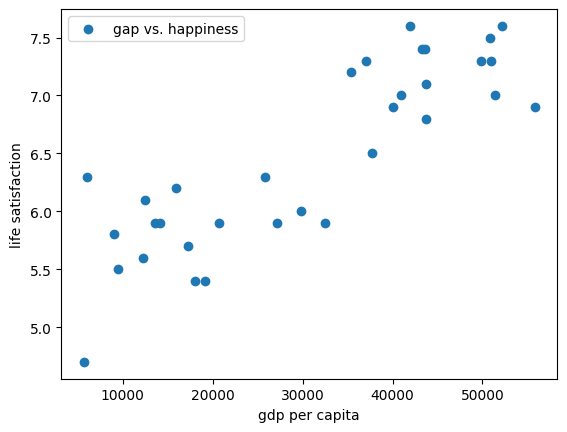

In [25]:
plt.scatter(sample_data.gdp_per_capita, sample_data.life_satisfaction, label = 'gap vs. happiness')
plt.xlabel('gdp per capita')
plt.ylabel('life satisfaction')
plt.legend()

plt.show()

In [26]:
sample_data[sample_data.country.isin(['Hungary','Korea','France','Australia','United States'])]

,country,gdp_per_capita,life_satisfaction
6,Hungary,12239.89,5.6
18,Korea,27195.20,5.9
23,France,37675.01,6.5
33,Australia,50961.87,7.3
36,United States,55805.20,6.9


/Users/xiangshiyin/Library/Caches/pypoetry/virtualenvs/data-programming-with-python-h2fMFruk-py3.10/lib/python3.10/site-packages/matplotlib/text.py:1461: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  x = float(self.convert_xunits(x))
/Users/xiangshiyin/Library/Caches/pypoetry/virtualenvs/data-programming-with-python-h2fMFruk-py3.10/lib/python3.10/site-packages/matplotlib/text.py:1463: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  y = float(self.convert_yunits(y))


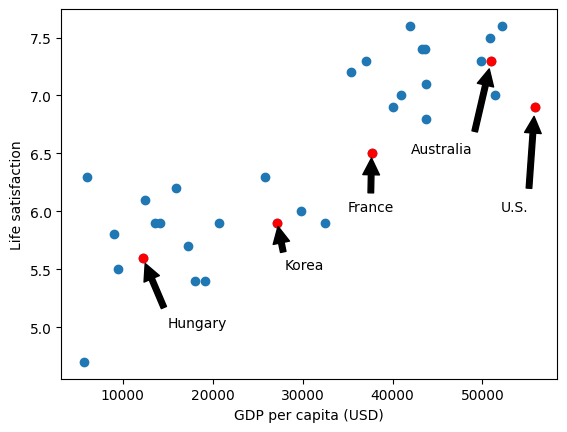

In [27]:
plt.scatter(sample_data.gdp_per_capita, sample_data.life_satisfaction)
position_text = {
    "Hungary": (15000, 5),
    "Korea": (28000, 5.5),
    "France": (35000, 6.0),
    "Australia": (42000, 6.5),
    "United States": (52000, 6.0),
}

for country, pos_text in position_text.items():
    pos_data_x = sample_data.loc[sample_data.country==country,'gdp_per_capita']
    pos_data_y = sample_data.loc[sample_data.country==country,'life_satisfaction']
    country = "U.S." if country == "United States" else country
    plt.annotate(country, xy=(pos_data_x, pos_data_y), xytext=pos_text,
            arrowprops=dict(facecolor='black', shrink=0.1))
    plt.plot(pos_data_x, pos_data_y, "ro")

plt.xlabel('GDP per capita (USD)')
plt.ylabel('Life satisfaction')
plt.show()

There seems to be a linear trend here!!

## Fit a linear regression model!

Linear regression model
$$
y = \theta_0 + \theta_1X
$$

The fit essentially minimized the Sum of Squared Errors (SSE)
$$
SSE = \sum_{i=1}^{N} (y_i - \hat{y_i})^2 = \sum_{i=1}^{N} (y_i - \theta_0 - \theta_1X_i)^2
$$
Or, in the matrix form
$$
SSE = ||y - Xw||^2
$$

![](https://nextjournal.com/data/QmfPuPp4V74FyvTTojMj6ix9T8Skj1ji4GhX5Pr6zK8w4N?filename=linear-regression.png&content-type=image/png)

In [28]:
%%time

from sklearn import linear_model
lr = linear_model.LinearRegression()

# prepare the data
Xsample = np.c_[sample_data.gdp_per_capita]
ysample = np.c_[sample_data.life_satisfaction]
# Xsample = sample_data.gdp_per_capita
# ysample = sample_data.life_satisfaction

# train the model
lr.fit(Xsample, ysample)

# get the model parameters
# t0, t1 = lr.intercept_[0], lr.coef_[0][0]
t0 = lr.intercept_[0]
t1 = lr.coef_[0][0]

t0, t1

CPU times: user 414 ms, sys: 92.9 ms, total: 507 ms
Wall time: 3.12 s


(5.166394143672077, 4.247060194254786e-05)

In [29]:
Xsample.ndim

2

In [30]:
Xsample.shape

(33, 1)

In [31]:
ysample.shape

(33, 1)

/Users/xiangshiyin/Library/Caches/pypoetry/virtualenvs/data-programming-with-python-h2fMFruk-py3.10/lib/python3.10/site-packages/matplotlib/text.py:1461: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  x = float(self.convert_xunits(x))
/Users/xiangshiyin/Library/Caches/pypoetry/virtualenvs/data-programming-with-python-h2fMFruk-py3.10/lib/python3.10/site-packages/matplotlib/text.py:1463: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  y = float(self.convert_yunits(y))


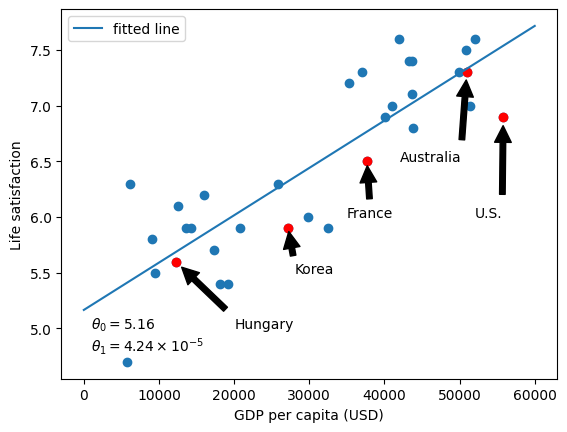

In [32]:
## same as previous plot
plt.scatter(sample_data.gdp_per_capita, sample_data.life_satisfaction)
position_text = {
    "Hungary": (20000, 5),
    "Korea": (28000, 5.5),
    "France": (35000, 6.0),
    "Australia": (42000, 6.5),
    "United States": (52000, 6.0),
}

for country, pos_text in position_text.items():
    pos_data_x = sample_data.loc[sample_data.country==country,'gdp_per_capita']
    pos_data_y = sample_data.loc[sample_data.country==country,'life_satisfaction']
    country = "U.S." if country == "United States" else country
    plt.annotate(country, xy=(pos_data_x, pos_data_y), xytext=pos_text,
            arrowprops=dict(facecolor='black', shrink=0.1))
    plt.plot(pos_data_x, pos_data_y, "ro")

## plot the fitted line here
X = np.linspace(start=0, stop=60000, num=1000)
plt.plot(X, t1*X + t0, label='fitted line')
plt.text(1000, 5, '$\\theta_0=5.16$')
plt.text(1000, 4.8, '$\\theta_1=4.24 \\times 10^{-5}$')
    
plt.xlabel('GDP per capita (USD)')
plt.ylabel('Life satisfaction')
plt.legend()
plt.show()

## Make predictions to a new country

In [33]:
gdp_per_capita2[gdp_per_capita2.country=='Cyprus']

,country,gdp_per_capita
42,Cyprus,22587.49


In [34]:
X_new = [[22587.49]]
lr.predict(X_new)

array([[6.12569844]])

In [35]:
gdp_per_capita2[gdp_per_capita2.country=='China']

,country,gdp_per_capita
34,China,7989.72


In [36]:
X_new = [[7989.72]]
lr.predict(X_new)

array([[5.50572236]])

## What happens when we add the missing countries back to the data?

In [37]:
missing_data

,country,gdp_per_capita,life_satisfaction
2,Brazil,8670.00,6.4
3,Mexico,9009.28,6.5
8,Chile,13340.91,6.5
12,Czech Republic,17256.92,6.7
37,Norway,74822.11,7.6
38,Switzerland,80675.31,7.5
39,Luxembourg,101994.09,6.9


In [38]:
%%time

lr2 = linear_model.LinearRegression()

# prepare the data
Xfull = np.c_[country_stats.gdp_per_capita]
yfull = np.c_[country_stats.life_satisfaction]

# train the model
lr2.fit(Xfull, yfull)

# get the model parameters
t0full, t1full = lr2.intercept_[0], lr2.coef_[0][0]
t0full, t1full

CPU times: user 1.77 ms, sys: 161 µs, total: 1.93 ms
Wall time: 1.96 ms


(5.72408173931895, 2.4690442763171645e-05)

/Users/xiangshiyin/Library/Caches/pypoetry/virtualenvs/data-programming-with-python-h2fMFruk-py3.10/lib/python3.10/site-packages/matplotlib/text.py:1461: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  x = float(self.convert_xunits(x))
/Users/xiangshiyin/Library/Caches/pypoetry/virtualenvs/data-programming-with-python-h2fMFruk-py3.10/lib/python3.10/site-packages/matplotlib/text.py:1463: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  y = float(self.convert_yunits(y))


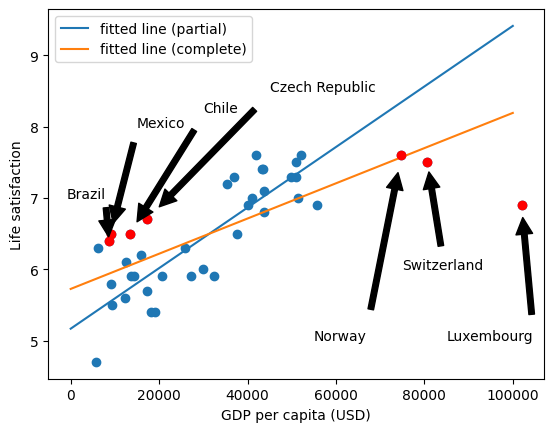

In [39]:
## same as previous plot
plt.scatter(country_stats.gdp_per_capita, country_stats.life_satisfaction)

X = np.linspace(start=0, stop=100000, num=1000)

## plot the fitted line based on partial dataset
plt.plot(X, t1*X + t0, label='fitted line (partial)')

## plot the fitted line of the complete dataset
plt.plot(X, t1full*X + t0full, label='fitted line (complete)')

## highlight the countries from the missing data
position_text2 = {
    "Brazil": (-1000, 7),
    "Mexico": (15000, 8),
    "Chile": (30000, 8.2),
    "Czech Republic": (45000, 8.5),
    "Norway": (55000, 5),
    "Switzerland": (75000, 6),
    "Luxembourg": (85000, 5)
}

for country, pos_text in position_text2.items():
    pos_data_x = country_stats.loc[country_stats.country==country,'gdp_per_capita']
    pos_data_y = country_stats.loc[country_stats.country==country,'life_satisfaction']
    country = "U.S." if country == "United States" else country
    plt.annotate(country, xy=(pos_data_x, pos_data_y), xytext=pos_text,
            arrowprops=dict(facecolor='black', shrink=0.1))
    plt.plot(pos_data_x, pos_data_y, "ro")

plt.xlabel('GDP per capita (USD)')
plt.ylabel('Life satisfaction')
plt.legend()
plt.show()

Apparently, the previous training data `sample_data` we used isn't representative!!

## Overfitting

In [40]:
## add polynomial features
from sklearn import preprocessing

df = 10
poly = preprocessing.PolynomialFeatures(degree=df)
scaler = preprocessing.StandardScaler()
lr3 = linear_model.LinearRegression()

Xfull_new = scaler.fit_transform(
    poly.fit_transform(Xfull)
)

## fit linear regression model on Xfull_new
lr3.fit(Xfull_new,yfull)

LinearRegression()

In [41]:
## define a set of new X
X = np.c_[np.linspace(start=0, stop=100000, num=1000)]

X_new = scaler.fit_transform(
    poly.fit_transform(X)
)

## predict on the new X
y = lr3.predict(X_new)

/Users/xiangshiyin/Library/Caches/pypoetry/virtualenvs/data-programming-with-python-h2fMFruk-py3.10/lib/python3.10/site-packages/matplotlib/text.py:1461: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  x = float(self.convert_xunits(x))
/Users/xiangshiyin/Library/Caches/pypoetry/virtualenvs/data-programming-with-python-h2fMFruk-py3.10/lib/python3.10/site-packages/matplotlib/text.py:1463: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  y = float(self.convert_yunits(y))


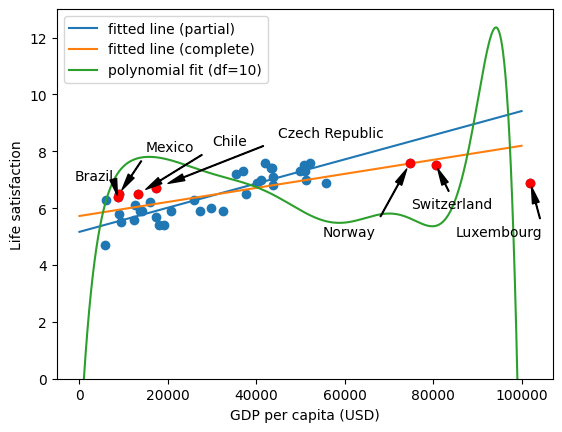

In [42]:
plt.scatter(country_stats.gdp_per_capita, country_stats.life_satisfaction)

## plot the fitted line based on partial dataset
plt.plot(X, t1*X + t0, label='fitted line (partial)')

## plot the fitted line of the complete dataset
plt.plot(X, t1full*X + t0full, label='fitted line (complete)')

## highlight the countries from the missing data
position_text2 = {
    "Brazil": (-1000, 7),
    "Mexico": (15000, 8),
    "Chile": (30000, 8.2),
    "Czech Republic": (45000, 8.5),
    "Norway": (55000, 5),
    "Switzerland": (75000, 6),
    "Luxembourg": (85000, 5)
}

for country, pos_text in position_text2.items():
    pos_data_x = country_stats.loc[country_stats.country==country,'gdp_per_capita']
    pos_data_y = country_stats.loc[country_stats.country==country,'life_satisfaction']
    country = "U.S." if country == "United States" else country
    plt.annotate(country, xy=(pos_data_x, pos_data_y), xytext=pos_text,
            arrowprops=dict(facecolor='black', width=0.5, shrink=0.1, headwidth=5))
    plt.plot(pos_data_x, pos_data_y, "ro")

## plot the polynomial fit
plt.plot(X,y,label='polynomial fit (df={})'.format(df))
    
    
plt.xlabel('GDP per capita (USD)')
plt.ylabel('Life satisfaction')
plt.ylim(0,13)
plt.legend()
plt.show()

## Apply L2 Regularization (Ridge Regression)

Instead of minimizing
$$
SSE = ||y - Xw||^2
$$

We will minimize
$$
SSE = ||y - Xw||^2 + \alpha ||w||^2
$$

In the 2D situation

$$
SSE = ||y - Xw||^2 + \alpha ||w||^2 = \sum_{i=1}^{N} (y_i - \theta_0 - \theta_1X_i)^2 + \alpha (\theta_0^2 + \theta_1^2)
$$

* https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html
* There is another kind of regularization called `L1 Regularization` (also called `Lasso Regression`)
    * More details can be found here: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html
    * Aur´elien G´eron `Hands-On Machine Learning with Scikit-Learn and TensorFlow` O’Reilly Media, 2022.
        * Chapter 4
    * Differences between `L1` and `L2` regularization
        * https://www.linkedin.com/pulse/intuitive-visual-explanation-differences-between-l1-l2-xiaoli-chen/
        * https://www.quora.com/What-is-the-difference-between-L1-and-L2-regularization-How-does-it-solve-the-problem-of-overfitting-Which-regularizer-to-use-and-when

The amount of regularization to apply during learning can be controlled by a hyperparameter. A hyperparameter is a parameter of a learning algorithm (not of the model). As such, it is not affected by the learning algorithm itself; it must be set prior to training and remains constant during training. 

Here, the parameter $\alpha$ is a hyperparamter. If you set the regularization hyperparameter to a very large value, you will get an almost flat model (a slope close to zero); the learning algorithm will almost certainly not overfit the training data, but it will be less likely to find a good solution. Tuning hyperparameters is an important part of building a Machine Learning system

In [43]:
## apply regularization on the original fit on sample_data
ridge = linear_model.Ridge(alpha=10**9.5)
Xsample = np.c_[sample_data.gdp_per_capita]
ysample = np.c_[sample_data.life_satisfaction]
ridge.fit(Xsample, ysample)
t0ridge, t1ridge = ridge.intercept_[0], ridge.coef_[0][0]

/Users/xiangshiyin/Library/Caches/pypoetry/virtualenvs/data-programming-with-python-h2fMFruk-py3.10/lib/python3.10/site-packages/matplotlib/text.py:1461: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  x = float(self.convert_xunits(x))
/Users/xiangshiyin/Library/Caches/pypoetry/virtualenvs/data-programming-with-python-h2fMFruk-py3.10/lib/python3.10/site-packages/matplotlib/text.py:1463: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  y = float(self.convert_yunits(y))


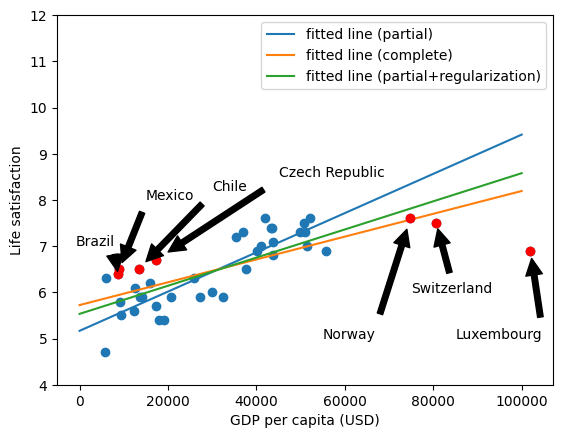

In [44]:
## same as previous plot
plt.scatter(country_stats.gdp_per_capita, country_stats.life_satisfaction)

X = np.linspace(start=0, stop=100000, num=1000)

## plot the fitted line based on partial dataset
plt.plot(X, t1*X + t0, label='fitted line (partial)')

## plot the fitted line of the complete dataset
plt.plot(X, t1full*X + t0full, label='fitted line (complete)')

## plot the fitted line based on partial dataset with regularization
plt.plot(X, t1ridge*X + t0ridge, label='fitted line (partial+regularization)')

## highlight the countries from the missing data
position_text2 = {
    "Brazil": (-1000, 7),
    "Mexico": (15000, 8),
    "Chile": (30000, 8.2),
    "Czech Republic": (45000, 8.5),
    "Norway": (55000, 5),
    "Switzerland": (75000, 6),
    "Luxembourg": (85000, 5)
}

for country, pos_text in position_text2.items():
    pos_data_x = country_stats.loc[country_stats.country==country,'gdp_per_capita']
    pos_data_y = country_stats.loc[country_stats.country==country,'life_satisfaction']
    country = "U.S." if country == "United States" else country
    plt.annotate(country, xy=(pos_data_x, pos_data_y), xytext=pos_text,
            arrowprops=dict(facecolor='black', shrink=0.1))
    plt.plot(pos_data_x, pos_data_y, "ro")

plt.xlabel('GDP per capita (USD)')
plt.ylabel('Life satisfaction')
plt.legend()
plt.ylim(4,12)
plt.show()

### Vary the regularization parameter $\alpha$

In [45]:
alphas = [10**i for i in range(20)]

In [46]:
Xsample = np.c_[sample_data.gdp_per_capita]
ysample = np.c_[sample_data.life_satisfaction]

In [47]:
%%time

from sklearn.metrics import mean_squared_error

rmses = []
r2s = []

for a in alphas:
    ridge = linear_model.Ridge(alpha=a)
    ridge.fit(Xsample, ysample)
    ysample_predict = ridge.predict(Xsample)
    rmse = mean_squared_error(ysample, ysample_predict)
    r2 = ridge.score(Xsample,ysample)
    
    rmses.append(rmse)
    r2s.append(r2)

CPU times: user 51.2 ms, sys: 2.64 ms, total: 53.9 ms
Wall time: 63.1 ms


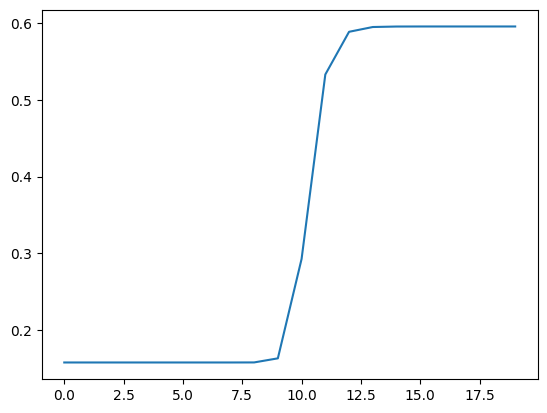

In [48]:
# plt.plot(alphas, rmses)
plt.plot(list(range(20)), rmses)
plt.show()

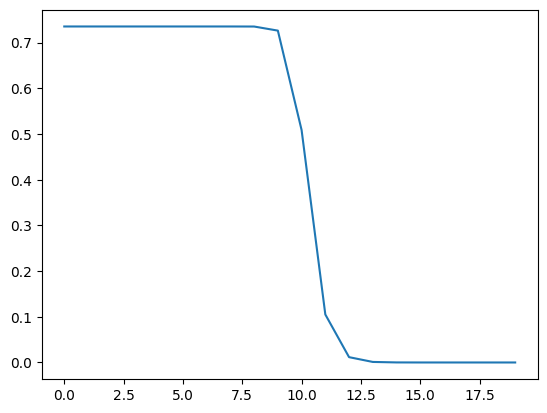

In [49]:
plt.plot(list(range(20)), r2s)
plt.show()